In [1]:
require(MathBioSim)
require(spatstat)
require(dplyr)
require(ggplot2)
require(foreach)
require(doParallel)

Loading required package: MathBioSim
Loading required package: Rcpp
Loading required package: devtools
Warning message:
"package 'devtools' was built under R version 3.5.1"Loading required package: spatstat
Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.56-0       (nickname: 'Bondi Tram') 
For an introduction to spatstat, type 'beginner' 


Note: spatstat version 1.56-0 is out of date by more than 3 months; we recommend upgrading to the latest version.
Loading required package: dplyr
Warning message:
"package 'dplyr' was built under R version 3.5.1"
Attaching package: 'dplyr'

The following object is masked from 'package:nlme':

    collapse

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: foreach
Warning message:
"package 'foreach' was buil

In [14]:
options(warn=-1)
registerDoParallel(makeCluster(detectCores() - 1))

sd_birth=seq(0.001,0.004,length.out = 7)
x_grid=seq(0,0.004*10,length.out=2001)

delta_time=250.0
n_samples=1000
time_start<-Sys.time()
print(Sys.time())
pcf_est_av<-foreach(sd_birth_i = sd_birth, 
                    .combine = list,
                    .multicombine = TRUE)%dopar%{
require(MathBioSim)
require(spatstat)
require(dplyr)          
params<-list(
            "area_length_x"=10,    
            "cell_count_x"=100,  
               
            "b"=0.3,    
            "d"=0,    
            "dd"=0.001, 
               
            "seed"=1234,  
            "init_density"=100,
               
            "death_kernel_x"=x_grid,
            "death_kernel_y"=dnorm(x_grid,sd=0.002),
               
            "birth_kernel_x"=x_grid,
            "birth_kernel_y"=dnorm(x_grid,sd=sd_birth_i), 
               
            "spline_precision" = 1e-6  
            )

sim<-new(poisson_1d,params)
  
  
pop<-numeric(n_samples)
pcf_estimate<-list()
  
for(j in 1:n_samples){
    sim$run_for(delta_time)
    pop[j]=sim$total_population
    points<-unique.ppp(ppp(sim$get_all_coordinates(),
                           rep(0,sim$total_population),
                           c(0,10),c(-5,5)
                           )
                       )
    K_estimate<-Kest(points,r=x_grid,correction="Ripley")
    
    pcf_estimate[[j]]=data.frame(Kest=K_estimate$iso/2,x=x_grid)%>%
                      mutate(pfc=(Kest-lag(Kest))/(x_grid-lag(x_grid))/sim$area_length_x)%>%
                      pull(pfc)
  }
  
  pcf_est_av<-numeric(length(x_grid))
  for(j in 1:length(pcf_estimate[[1]])){
    jrow=numeric(n_samples)
    for (k in 1:n_samples){
      jrow[k]=pcf_estimate[[k]][j]
    }
    pcf_est_av[j]=mean(jrow)
  }
  
  list(pcf_est_av,pop)
}

print(Sys.time()-time_start)
options(warn=0)

[1] "2018-10-04 11:52:25 MSK"
Time difference of 1.540223 hours


In [15]:
options(repr.plot.width=20, repr.plot.height=10)

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

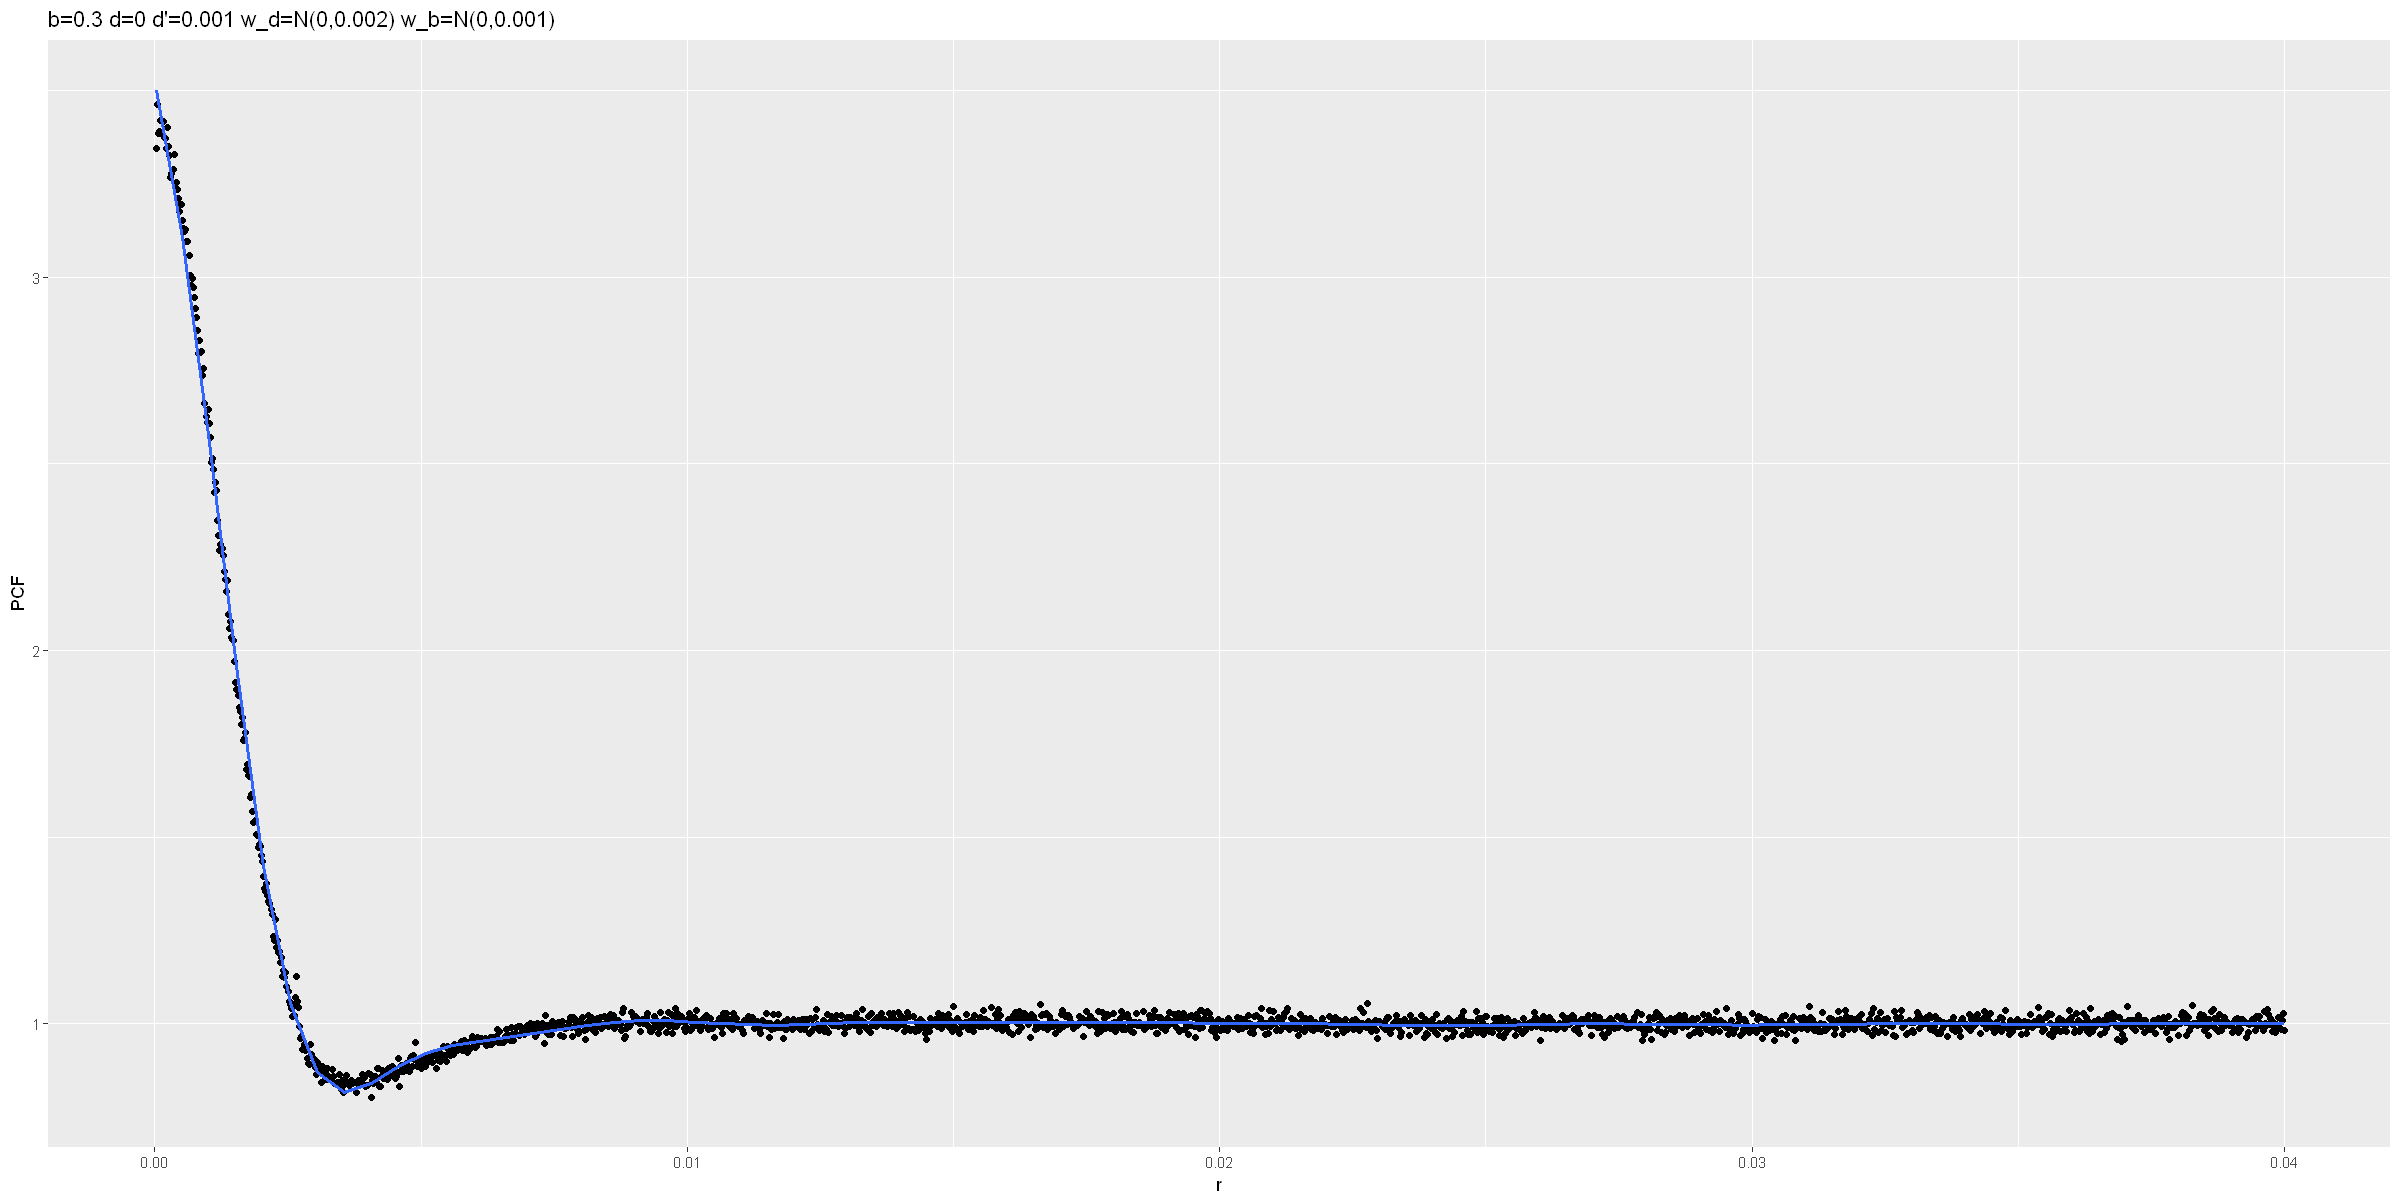

In [16]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[1]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.001)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

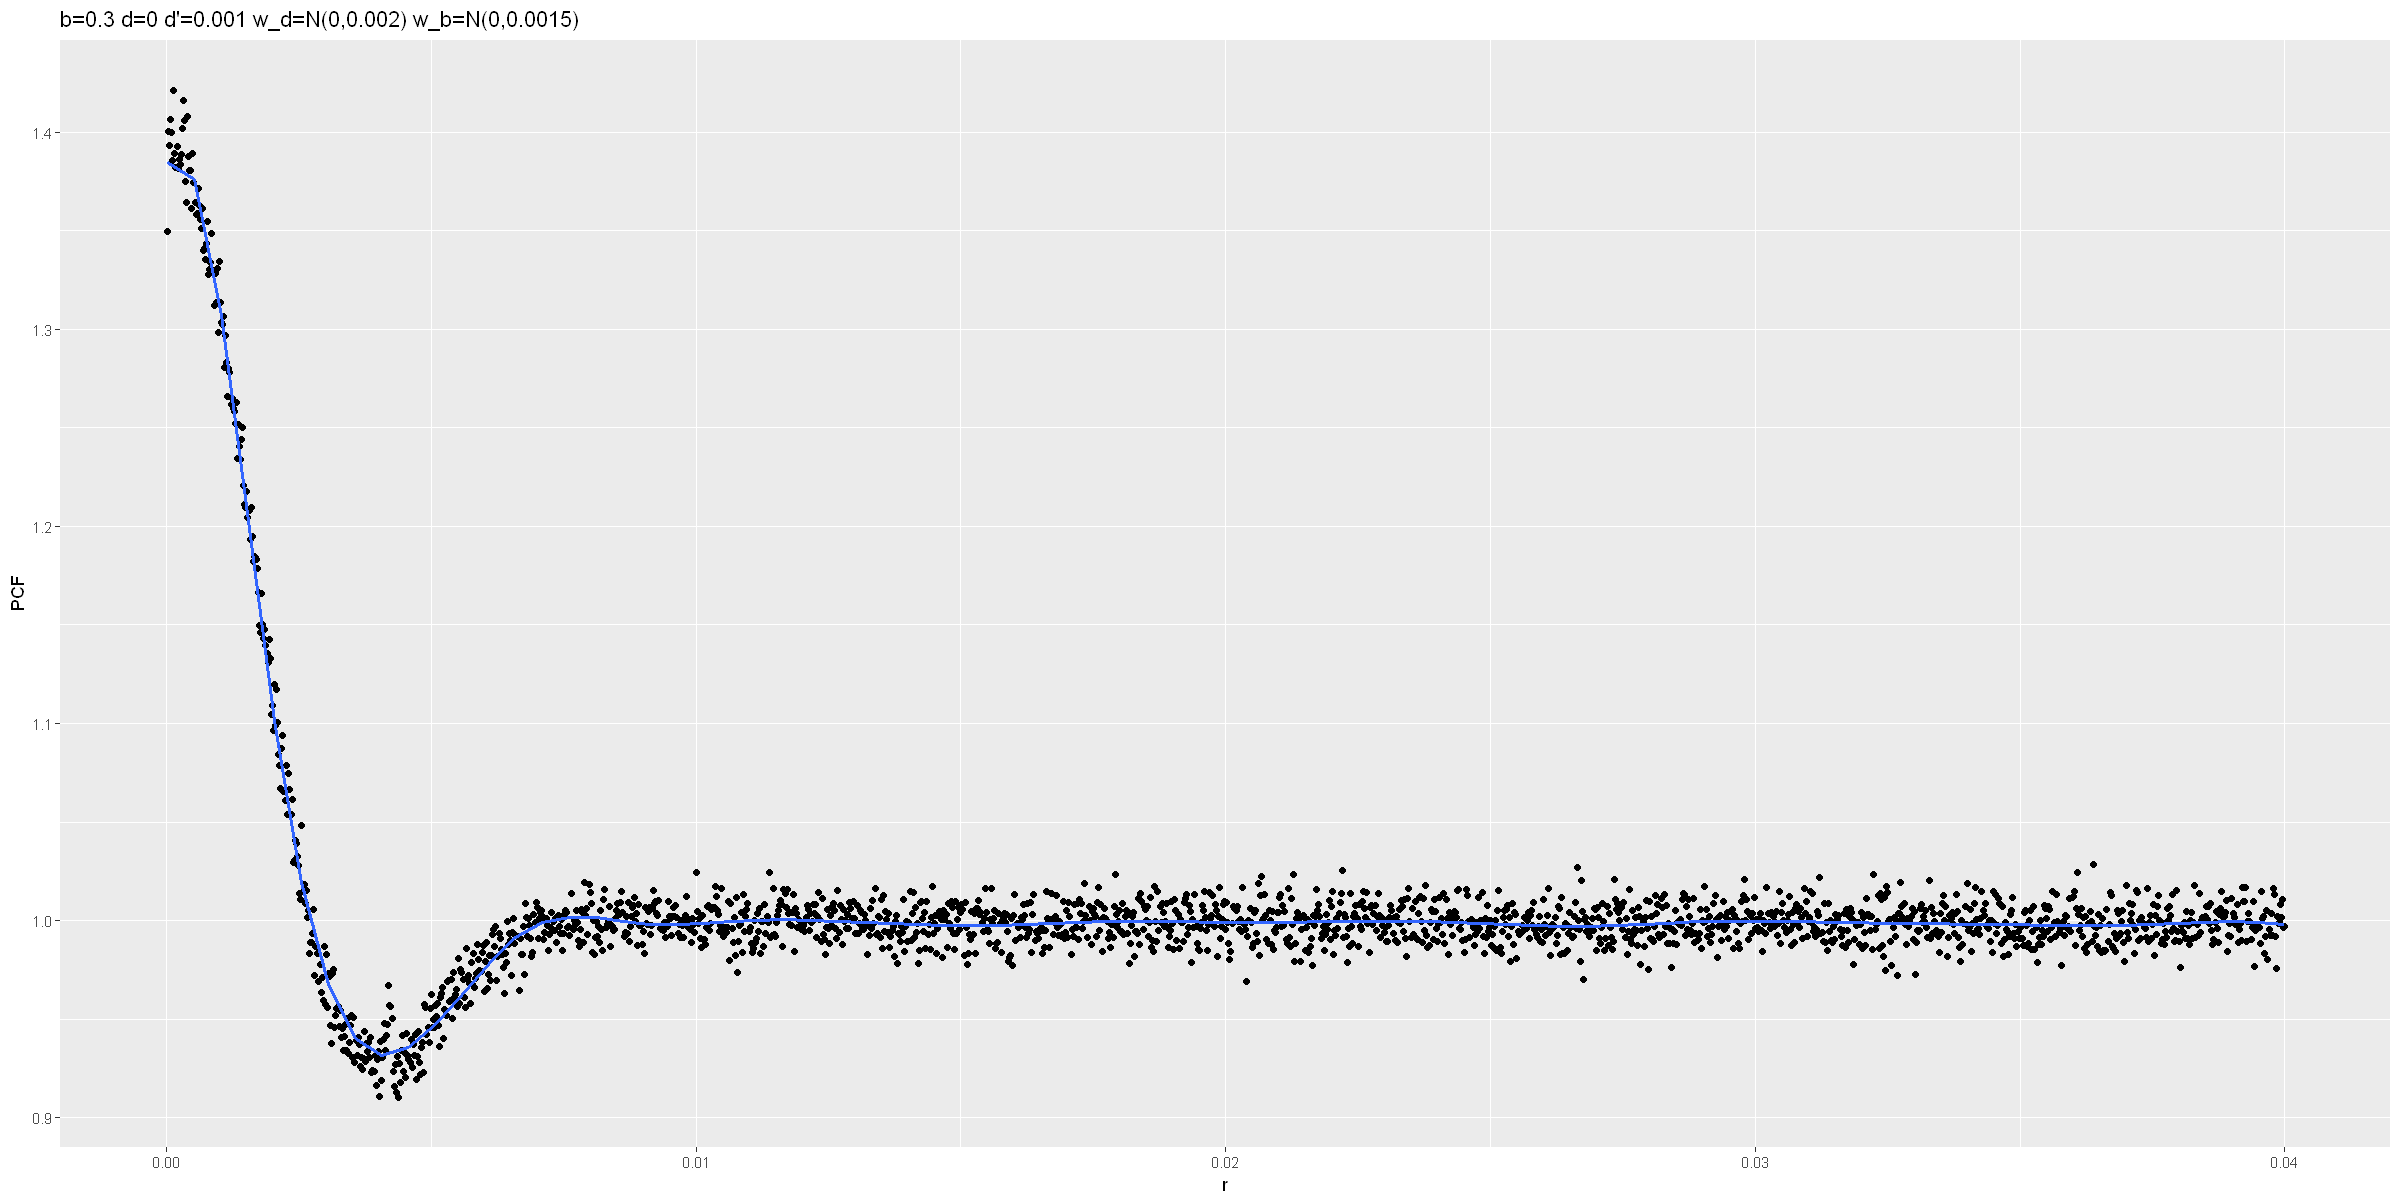

In [17]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[2]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0015)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

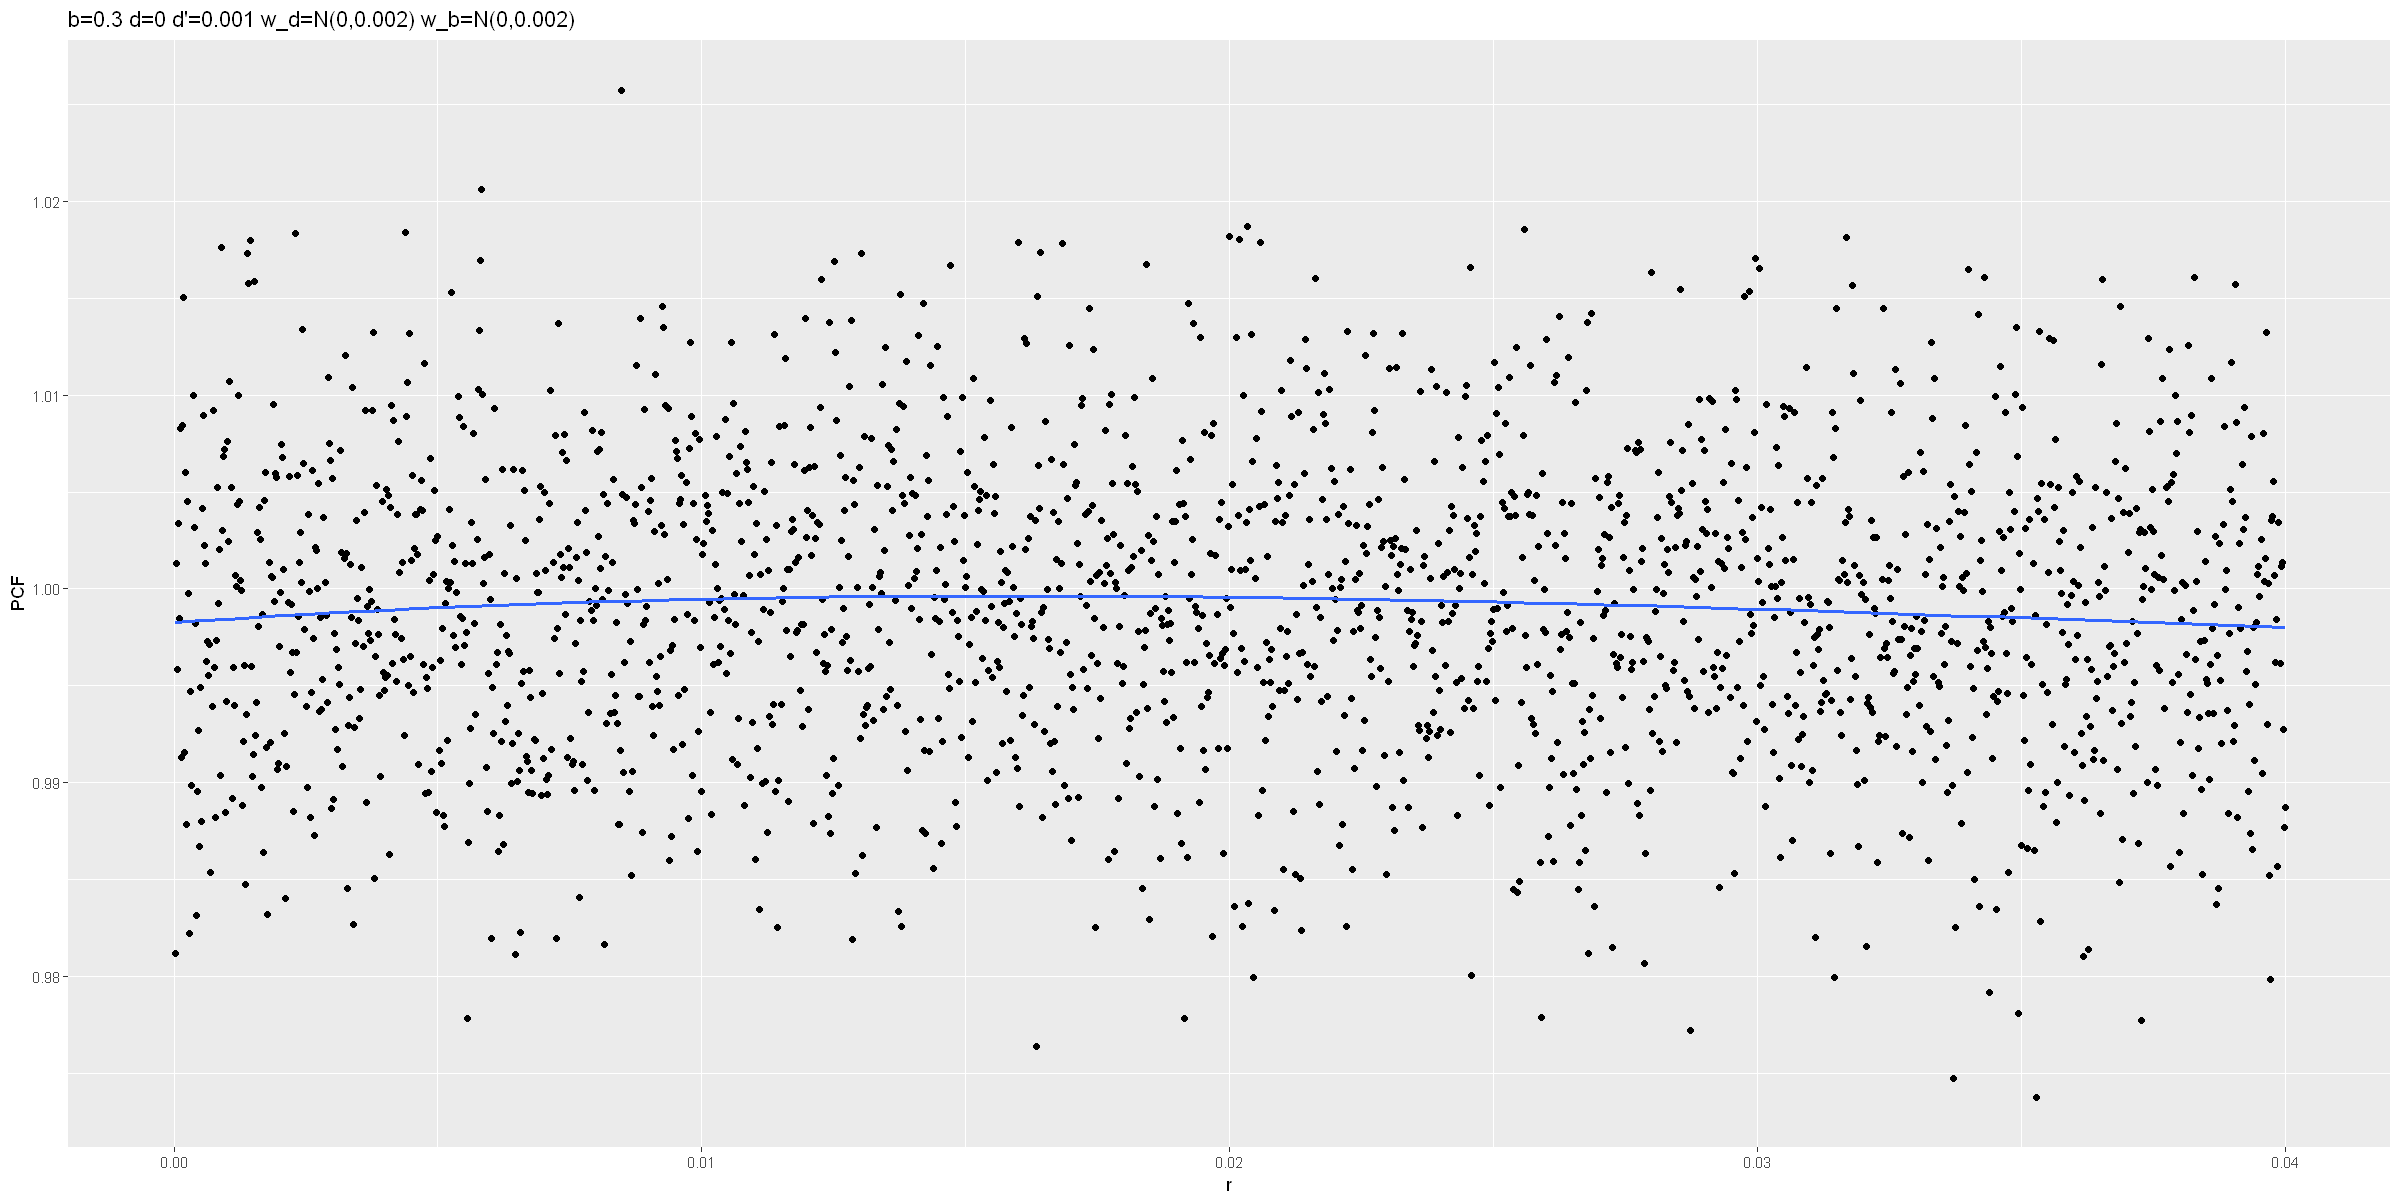

In [18]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[3]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 3), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.002)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

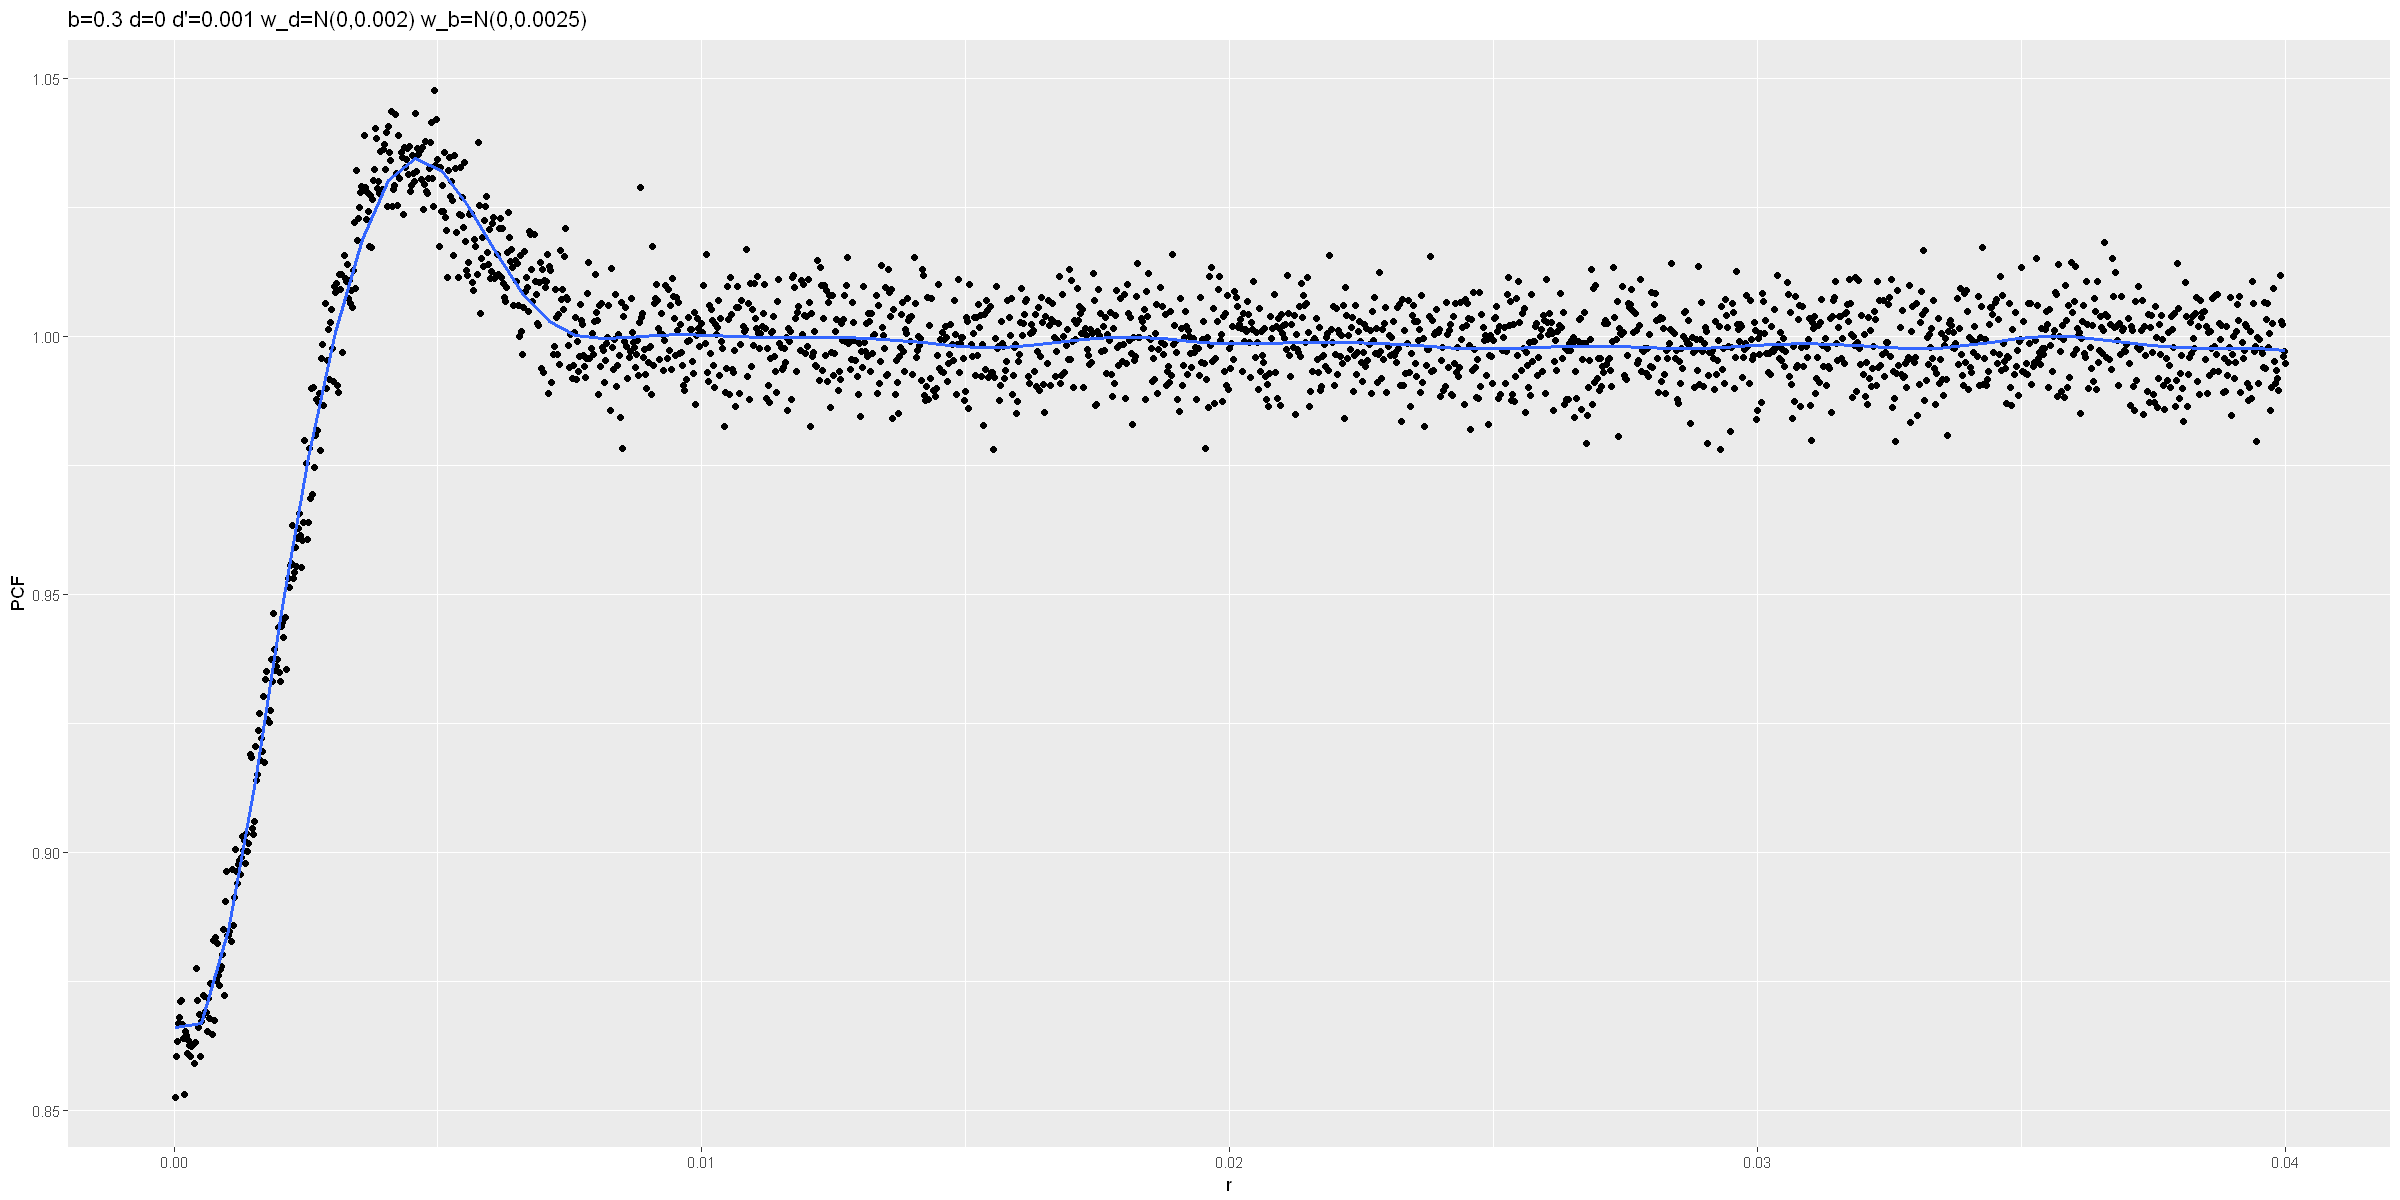

In [19]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[4]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0025)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

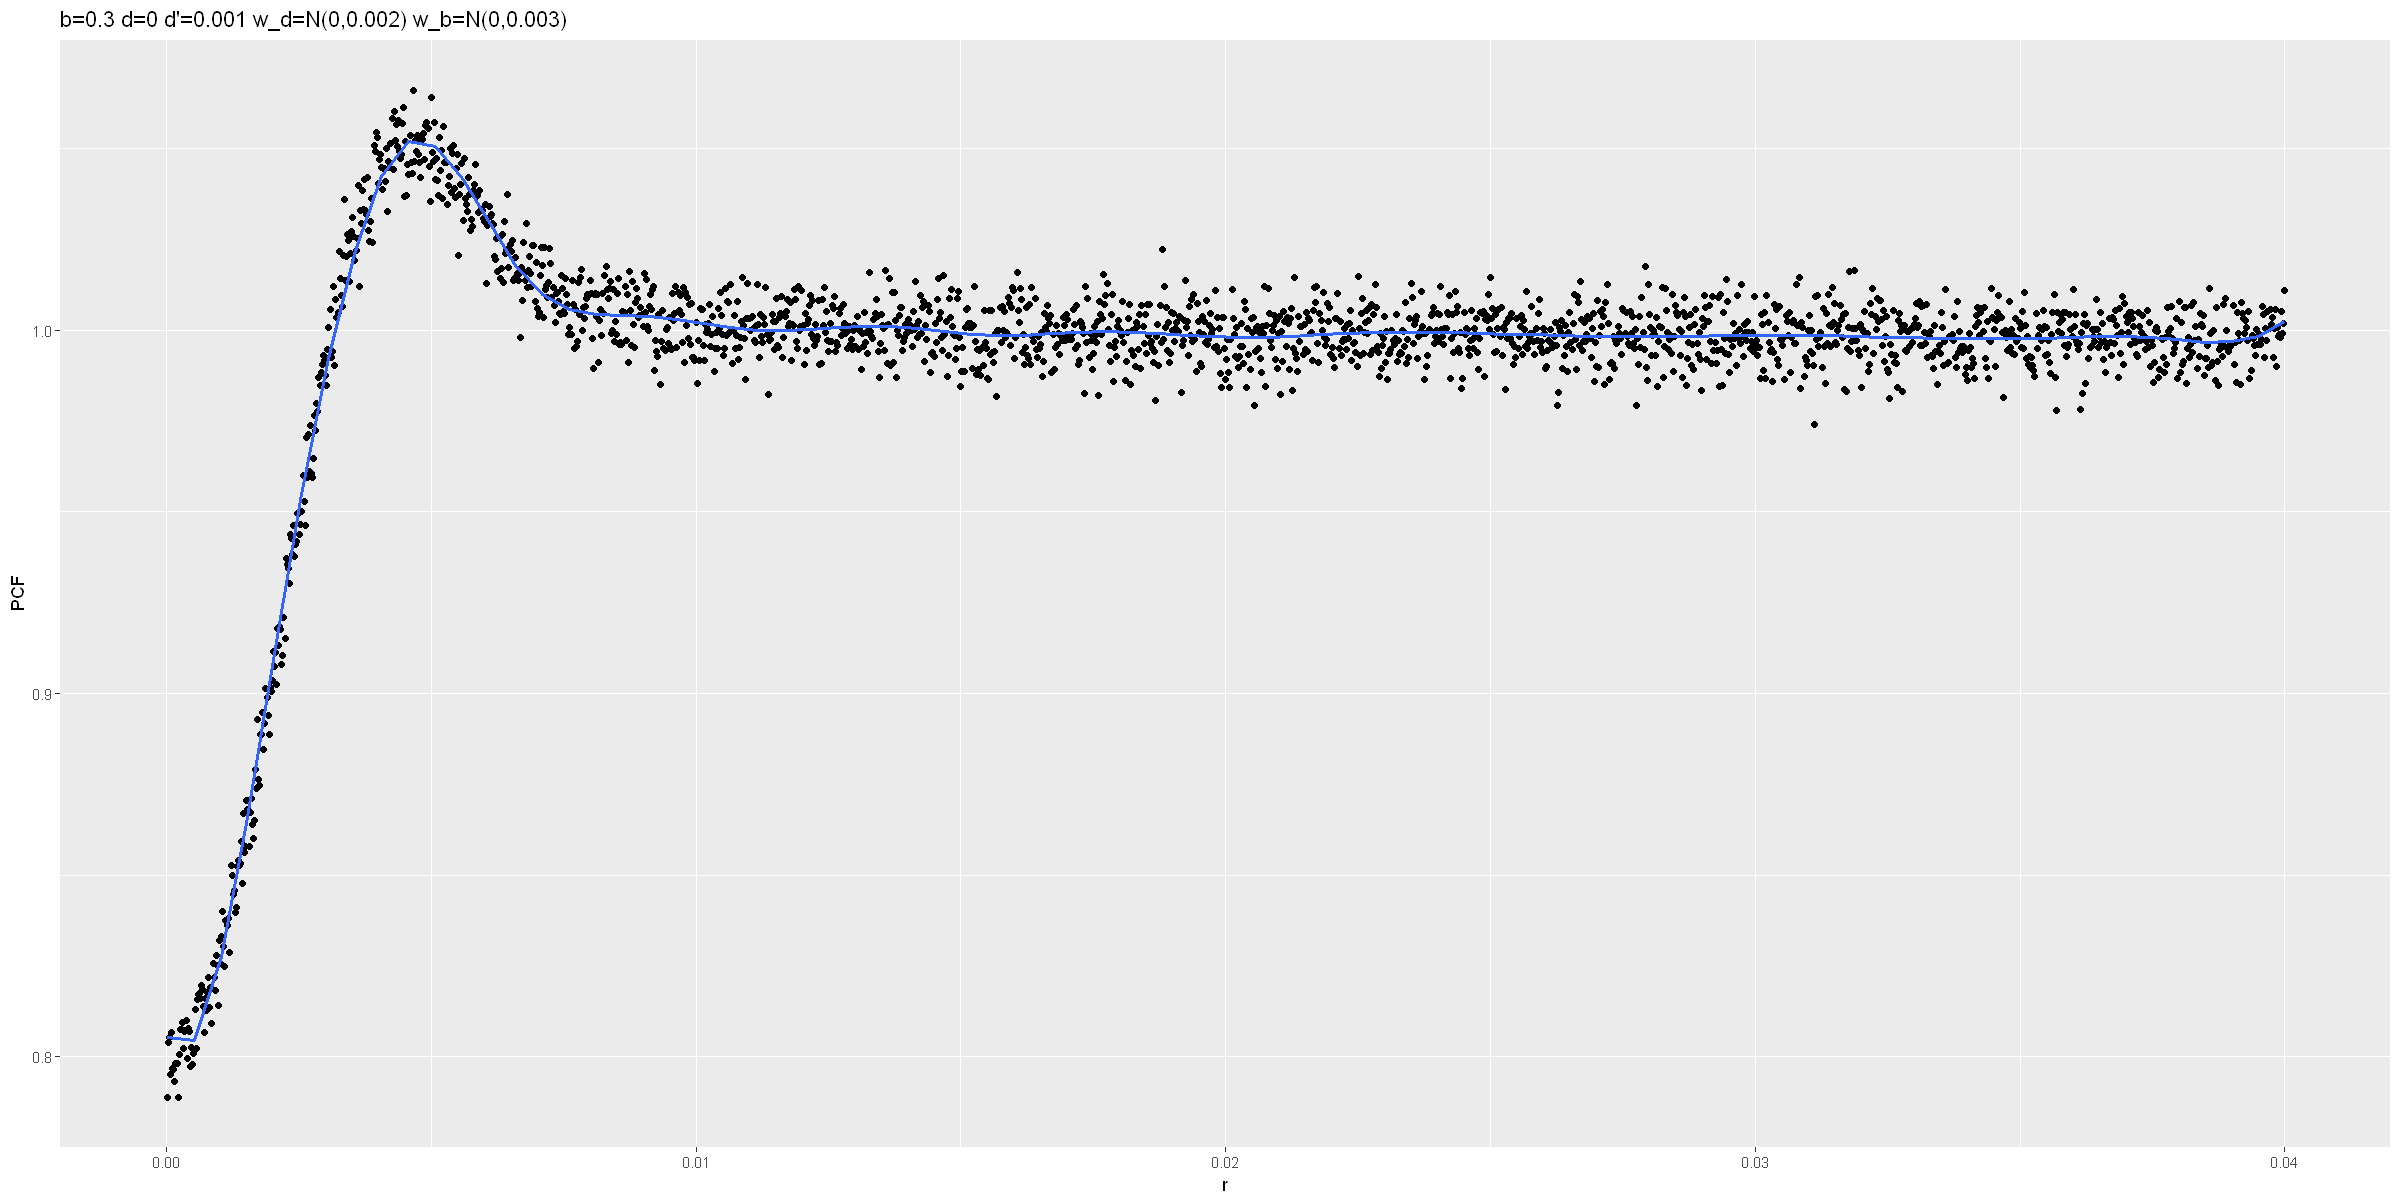

In [20]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[5]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.003)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

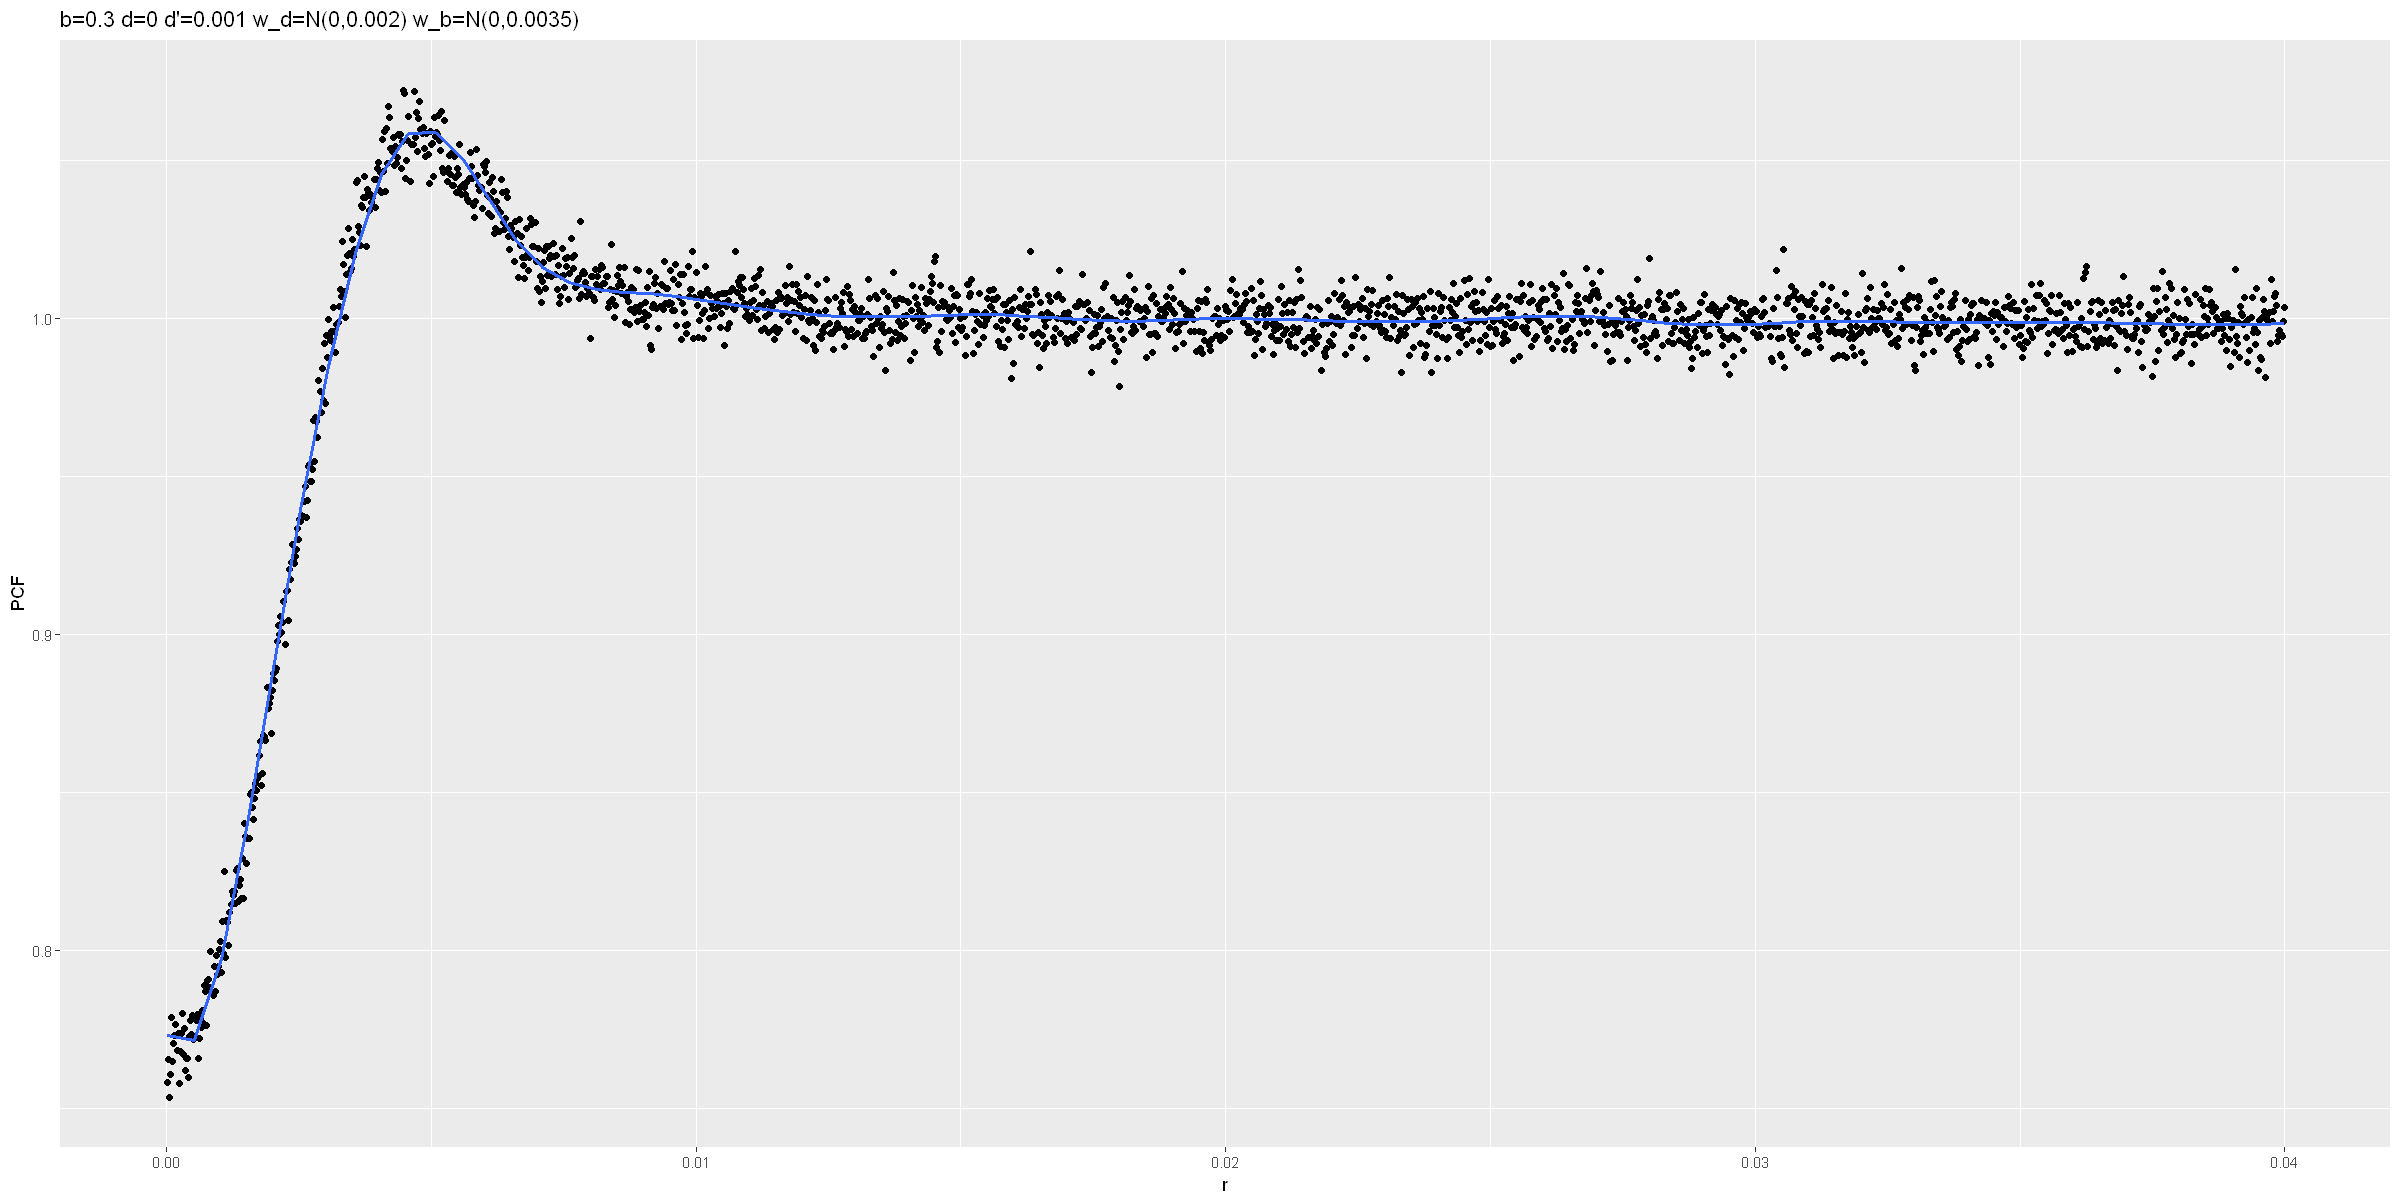

In [21]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[6]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.0035)")

Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

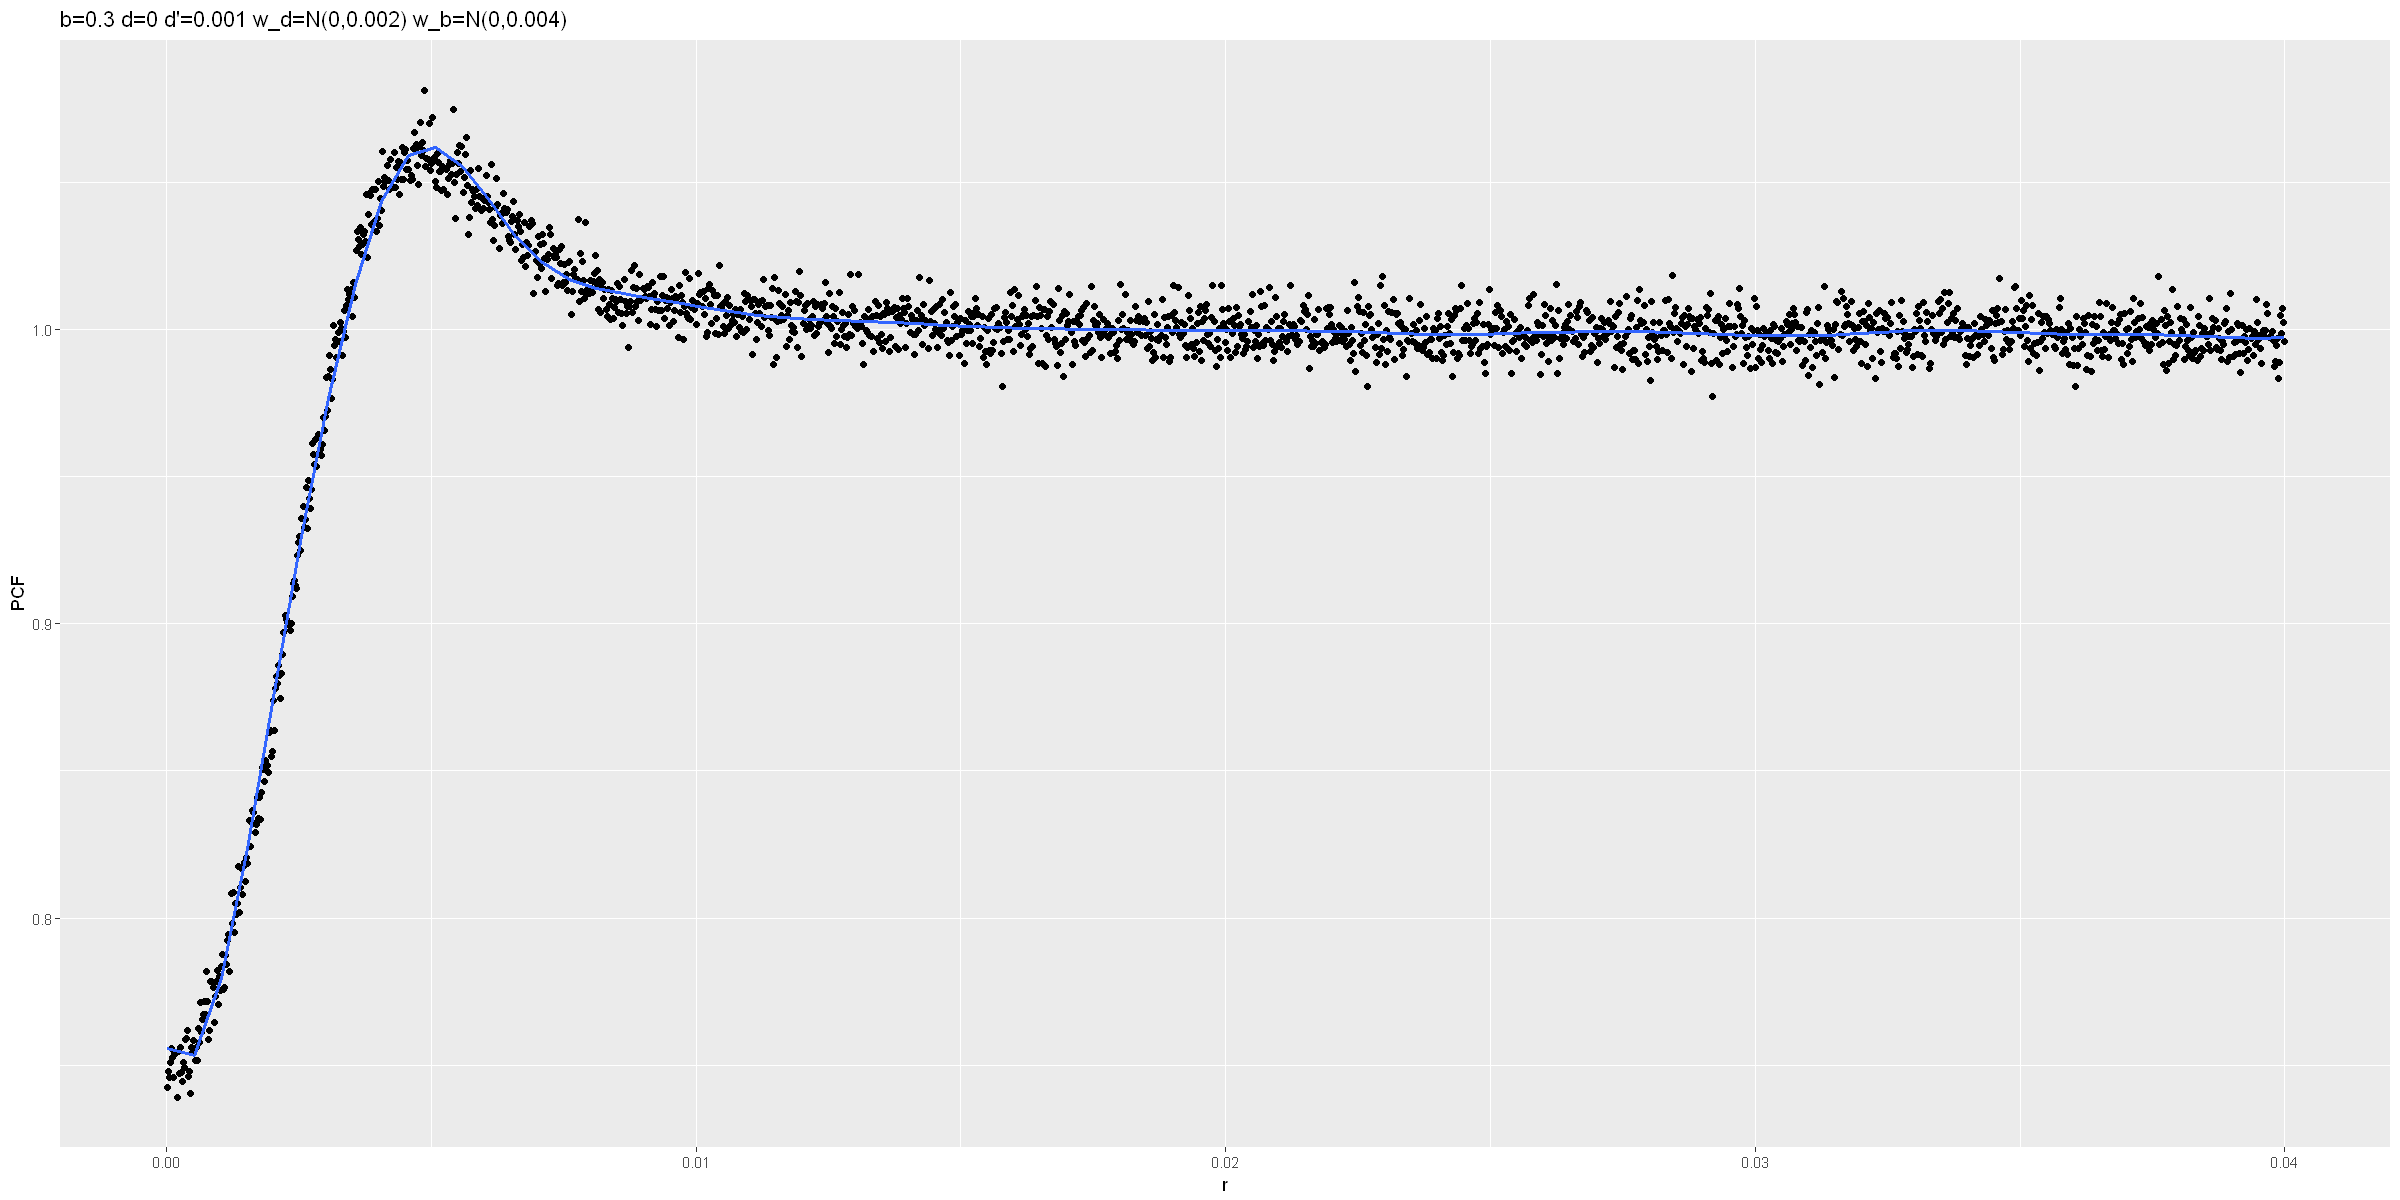

In [22]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av[[7]][[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.3 d=0 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.004)")

In [23]:
sapply(1:7,function(i){mean(pcf_est_av[[i]][[2]])})/10

[1] 141.4105 248.7239 300.0290 326.2635 341.2288 350.4017 356.6279

In [24]:
sapply(1:7,
       function(i){
           dif=pcf_est_av[[i]][[2]]-lag(pcf_est_av[[i]][[2]])
           print(t.test(dif)) 
                  } 
      )


	One Sample t-test

data:  dif
t = 0.017485, df = 998, p-value = 0.9861
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -3.785620  3.853688
sample estimates:
 mean of x 
0.03403403 


	One Sample t-test

data:  dif
t = 0.040568, df = 998, p-value = 0.9676
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.647101  4.843297
sample estimates:
mean of x 
0.0980981 


	One Sample t-test

data:  dif
t = 0.036425, df = 998, p-value = 0.971
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.975035  5.163223
sample estimates:
 mean of x 
0.09409409 


	One Sample t-test

data:  dif
t = 0.023192, df = 998, p-value = 0.9815
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -4.603252  4.713362
sample estimates:
 mean of x 
0.05505506 


	One Sample t-test

data:  dif
t = 0.065443, df = 998, p-value = 0.9478
alternative hypothesis: true mean is not equal

statistic,0.01748496,0.04056778,0.03642538,0.02319232,0.06544264,0.02449018,0.02544808
parameter,998,998,998,998,998,998,998
p.value,0.9860532,0.9676486,0.9709505,0.9815015,0.9478347,0.9804665,0.9797027
conf.int,"-3.785620, 3.853688","-4.647101, 4.843297","-4.975035, 5.163223","-4.603252, 4.713362","-4.381223, 4.683525","-4.673213, 4.791331","-4.571272, 4.691392"
estimate,0.03403403,0.0980981,0.09409409,0.05505506,0.1511512,0.05905906,0.06006006
null.value,0,0,0,0,0,0,0
alternative,two.sided,two.sided,two.sided,two.sided,two.sided,two.sided,two.sided
method,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test,One Sample t-test
data.name,dif,dif,dif,dif,dif,dif,dif


[1] -996

In [25]:
options(warn=-1)

sd_birth=0.001
x_grid=seq(0,0.004*10,length.out=2001)

delta_time=250.0
n_samples=100
time_start<-Sys.time()
pcf_est_av_1<-foreach(sd_birth_i = sd_birth, 
                    .combine = list,
                    .multicombine = TRUE)%do%{
require(MathBioSim)
require(spatstat)
require(dplyr)          
params<-list(
            "area_length_x"=10,    
            "cell_count_x"=100,  
               
            "b"=0.9,    
            "d"=0.14,    
            "dd"=0.001, 
               
            "seed"=1234,  
            "init_density"=100,
               
            "death_kernel_x"=x_grid,
            "death_kernel_y"=dnorm(x_grid,sd=0.002),
               
            "birth_kernel_x"=x_grid,
            "birth_kernel_y"=dnorm(x_grid,sd=sd_birth_i), 
               
            "spline_precision" = 1e-6  
            )

sim<-new(poisson_1d,params)
  
  
pop<-numeric(n_samples)
pcf_estimate<-list()
  
for(j in 1:n_samples){
    sim$run_for(delta_time)
    pop[j]=sim$total_population
    points<-unique.ppp(ppp(sim$get_all_coordinates(),
                           rep(0,sim$total_population),
                           c(0,10),c(-5,5)
                           )
                       )
    K_estimate<-Kest(points,r=x_grid,correction="Ripley")
    
    pcf_estimate[[j]]=data.frame(Kest=K_estimate$iso/2,x=x_grid)%>%
                      mutate(pfc=(Kest-lag(Kest))/(x_grid-lag(x_grid))/sim$area_length_x)%>%
                      pull(pfc)
  }
  
  pcf_est_av<-numeric(length(x_grid))
  for(j in 1:length(pcf_estimate[[1]])){
    jrow=numeric(n_samples)
    for (k in 1:n_samples){
      jrow[k]=pcf_estimate[[k]][j]
    }
    pcf_est_av[j]=mean(jrow)
  }
  
  list(pcf_est_av,pop)
}

print(Sys.time()-time_start)
options(warn=0)

Time difference of 26.53054 mins


Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

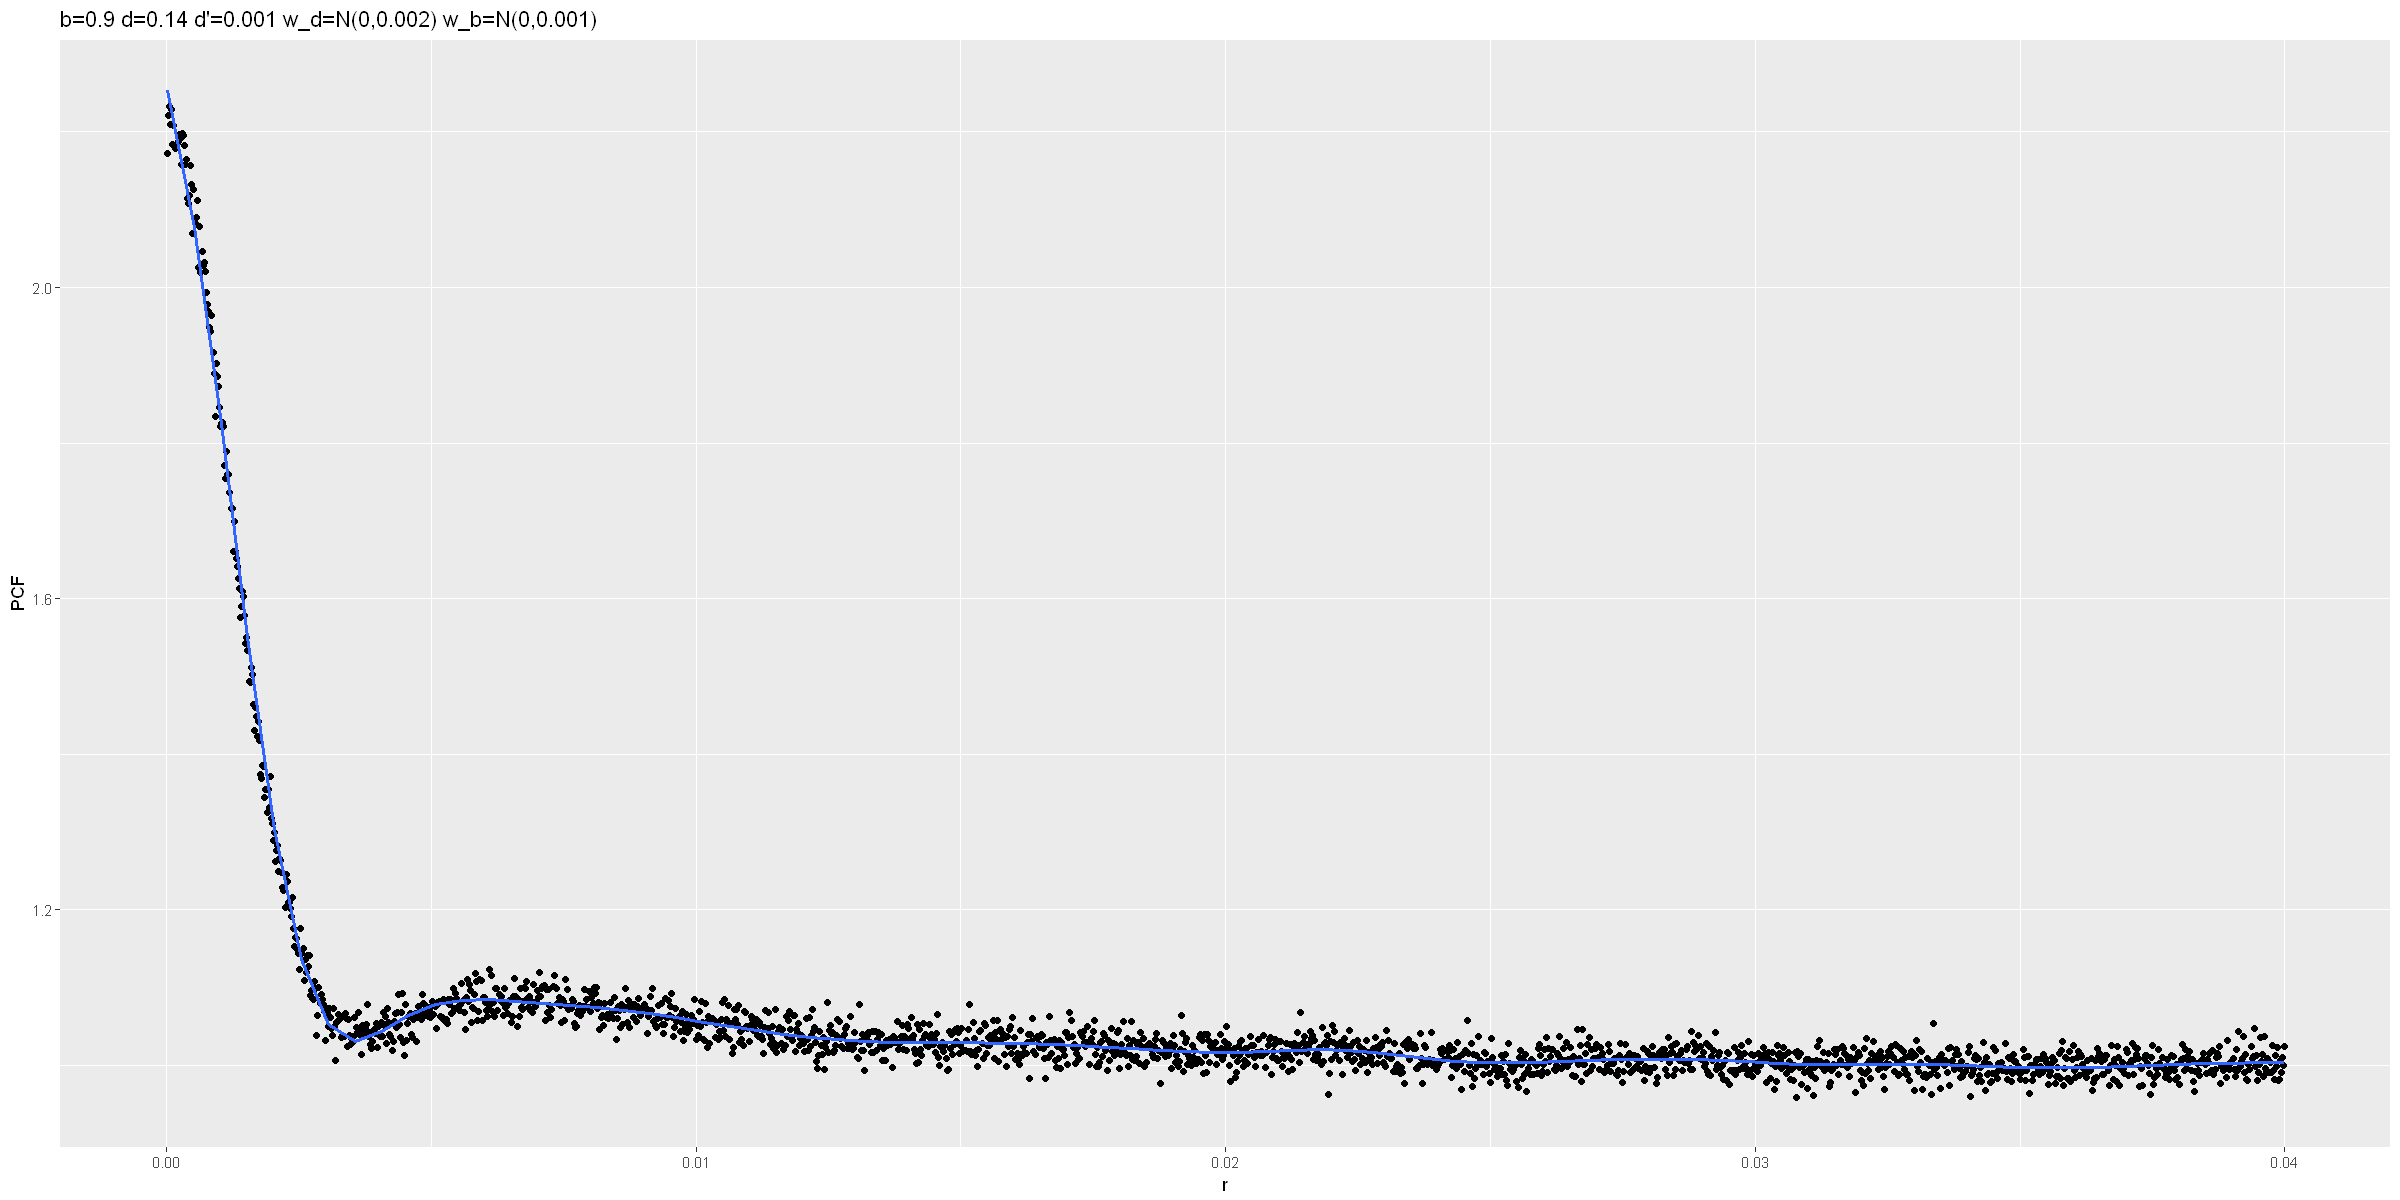

In [28]:
ggplot(data=data.frame(x=x_grid,y=pcf_est_av_1[[1]]),aes(x=x,y=y))+
  geom_point()+
  geom_smooth(method = "lm", formula = y ~ splines::bs(x, 20), se = FALSE)+
  labs(x="r",y="PCF",
       title="b=0.9 d=0.14 d'=0.001 w_d=N(0,0.002) w_b=N(0,0.001)")

In [29]:
mean(pcf_est_av_1[[2]])

[1] 4674.65

In [30]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] bindrcpp_0.2.2      doParallel_1.0.14   iterators_1.0.10   
 [4] foreach_1.4.4       ggplot2_2.2.1       dplyr_0.7.6        
 [7] spatstat_1.56-0     rpart_4.1-13        nlme_3.1-137       
[10] spatstat.data_1.3-1 MathBioSim_1.1      devtools_1.13.6    
[13] Rcpp_0.12.17       

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3         tidyselect_0.2.4     repr_0.15.0         
 [4] purrr_0.2.4          splines_3.5.0        lattice_0.20-35     
 [7] colorspace_1.3-2     spats